# Uitesten model met undersampled methode

## Imports & setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os

# importeren van zelf geschreven modules
from Callbacks.RealTimePlotCallback import RealTimePlotCallback
from dataset_module import dataset_creation

In [2]:
while os.getcwd() != "C:\\My Projects\\Opdracht-schilders":
    os.chdir('..')

os.chdir("Verder optimaliseren model/5.2 undersampled strategie")
os.getcwd()

'C:\\My Projects\\Opdracht-schilders\\Verder optimaliseren model\\5.2 undersampled strategie'

In [3]:
classes = os.listdir("paintings")

In [4]:
(train_data, train_labels) = dataset_creation.create_data_with_labels("undersampled_dataset/train/")
(val_data, val_labels) = dataset_creation.create_data_with_labels("undersampled_dataset/validation")
(test_data, test_labels) = dataset_creation.create_data_with_labels("undersampled_dataset/test")

undersampled_dataset\train\Picasso\29.jpg --> FAILED


## Model

Hieronder ziet u het model die ik gekozen heb als mijn finale model. Ik zal deze nu laten trainen op de undersampled dataset.

In [10]:
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)

# alle lagen behalve de laatste 4 freezen
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

input_layer = keras.Input(shape=(180, 180, 3))
x = conv_base(input_layer)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)


model.compile(loss="sparse_categorical_crossentropy",
     optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
     metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

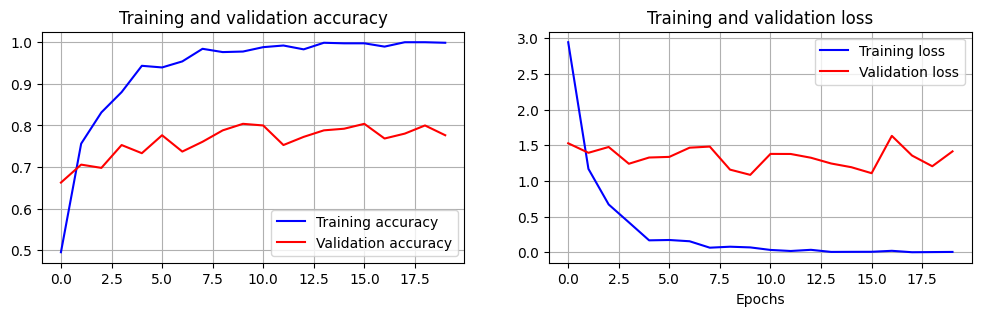

training loss: 0.005337789189070463
validation loss: 1.4152295589447021
training accuracy: 0.9986824989318848
validation accuracy: 0.7764706015586853

epochs: 20

24/24 [==============================] - 3s 113ms/step - loss: 0.0053 - accuracy: 0.9987 - val_loss: 1.4152 - val_accuracy: 0.7765


In [11]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="ResNet_undersampled.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_accuracy"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=50,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

We zien dat de validatie loss niet meer de training loss volgt na 1 epoch, dit wijst op overfitting. Ik zal het model in de volgende stap eens uitproberen met data augmentation.

8/8 [==============================] - 1s 83ms/step


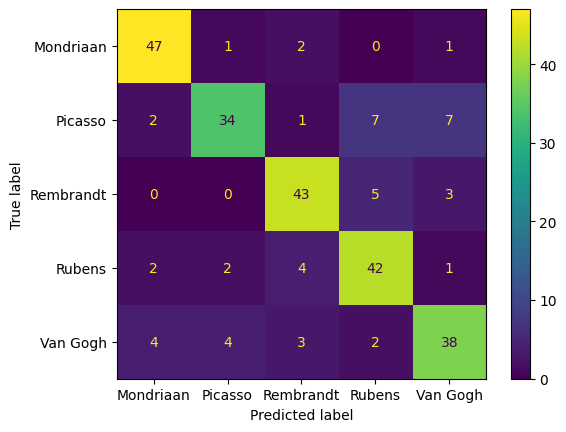

In [12]:
model = keras.models.load_model("ResNet_undersampled.keras")
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(model.predict(test_data), axis=-1))
ConfusionMatrixDisplay(cm, display_labels=classes).plot()
plt.show()

Op de confusion matrix zien we dat het model veel verschillende schilders door elkaar haalt.

In [14]:
model = keras.models.load_model("ResNet_undersampled.keras")
model.evaluate(test_data, test_labels)

8/8 [==============================] - 2s 68ms/step - loss: 0.8346 - accuracy: 0.8000


[0.8345950841903687, 0.800000011920929]

## Toevoegen data augmentation

Ik volg dezelfde redenering als deze die ik in "4.1 Eigen Convolutioneel Netwerk" heb gesteld over de data augmentation. Daar vertel ik u welke data augmentation layers ik gebruik en waarom.

In [5]:
conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False)

# alle lagen behalve de laatste 4 freezen
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

data_augmentation = tf.keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.3),
            layers.RandomZoom(0.2),
            # layers.RandomTranslation(0.2, 0.2)
        ]
)

input_layer = keras.Input(shape=(180, 180, 3))
x = data_augmentation(input_layer)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(input_layer, outputs)


model.compile(loss="sparse_categorical_crossentropy",
     optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
     metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

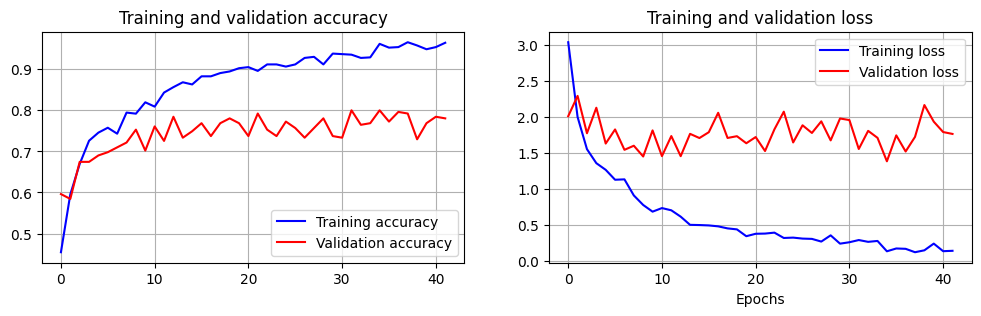

training loss: 0.1443435102701187
validation loss: 1.7679156064987183
training accuracy: 0.9644268751144409
validation accuracy: 0.7803921699523926

epochs: 42

24/24 [==============================] - 9s 367ms/step - loss: 0.1443 - accuracy: 0.9644 - val_loss: 1.7679 - val_accuracy: 0.7804


In [6]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="ResNet_undersampled_data_augmentation.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_accuracy"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data, train_labels,
         epochs=50,
         validation_data=(val_data, val_labels),
         callbacks=callbacks_list)

Zelfs met data augmentation bekomen we slechtere resultaten dan met de oversampled methode.

8/8 [==============================] - 1s 86ms/step


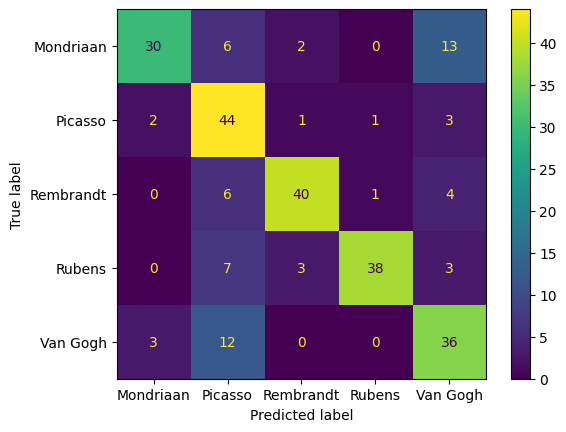

In [7]:
model = keras.models.load_model("ResNet_undersampled_data_augmentation.keras")
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(model.predict(test_data), axis=-1))
ConfusionMatrixDisplay(cm, display_labels=classes).plot()
plt.show()

In [8]:
model = keras.models.load_model("ResNet_undersampled_data_augmentation.keras")
model.evaluate(test_data, test_labels)

8/8 [==============================] - 1s 72ms/step - loss: 1.4521 - accuracy: 0.7373


[1.452121376991272, 0.7372549176216125]

We bekomen veel slechtere resultaten met ons model met de undersampled strategie.

# Conclusie

Ik bekom een veel beter resultaat met mijn model wanneer ik deze toepas op de dataset met de oversampled strategie. Dit vind ik niet meteen verrassend aangezien het model dan meer afbeeldingen heeft waarop het kan trainen.

Zoals ik al zei in de setup.ipynb van "2. Data exploration & setup" lijkt het me jammer dat we deze schilderijen hebben maar toch niet zouden gebruiken voor het model aangezien we deze moeten verwijderen voor de undersampled strategie zodat de klassen allemaal even groot zijn.